# 1. Importar paquetes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import itertools
from openpyxl import load_workbook
import math

import sys
sys.path.insert(0, 'Script')
from plot_functions import plot_distribution, plot_allboxplot, plotSTPrecipitación,plotSTBancoCentral, plotSTbyYearPrecipitación

def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier
def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

pd.options.display.float_format = "{:.3f}".format
pd.options.display.max_columns = None
pd.options.display.max_rows    = None

# 2. Lectura, visualización y análisis de archivos

## 2.1 Lectura y visualización de archivo "precipitaciones.csv"

In [2]:
precipitaciones = pd.read_csv("Data\precipitaciones.csv")
precipitaciones['date'] = pd.to_datetime(precipitaciones['date'], format="%Y-%m-%d")
precipitaciones.sort_values("date", inplace=True)
display(precipitaciones.head())
display(precipitaciones.info())

,date,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios
170,1979-01-01,2.642,0.587,2.447,1.609,3.736,17.860,25.213,45.596
465,1979-02-01,1.180,2.432,3.998,4.346,16.348,17.681,18.085,34.075
305,1979-03-01,0.255,0.021,0.000,0.055,0.545,14.436,28.697,66.232
441,1979-04-01,10.174,11.746,13.722,12.989,21.881,39.136,43.618,73.548
217,1979-05-01,1.039,18.609,50.187,104.452,143.914,219.729,279.410,438.005


<class 'pandas.core.frame.DataFrame'>
Int64Index: 496 entries, 170 to 144
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 496 non-null    datetime64[ns]
 1   Coquimbo                             496 non-null    float64       
 2   Valparaiso                           496 non-null    float64       
 3   Metropolitana_de_Santiago            496 non-null    float64       
 4   Libertador_Gral__Bernardo_O_Higgins  496 non-null    float64       
 5   Maule                                496 non-null    float64       
 6   Biobio                               496 non-null    float64       
 7   La_Araucania                         496 non-null    float64       
 8   Los_Rios                             496 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 38.8 KB


None

In [3]:
if len(precipitaciones.date.unique()) == precipitaciones.date.count():
    print("No hay fechas con registros duplicados")
else:
    n = precipitaciones.count() - len(precipitaciones.date.unique())
    print("Existen "+str(n)+" fechas duplicadas")
None if (precipitaciones.index.name == "date") else precipitaciones.set_index("date", inplace=True)

No hay fechas con registros duplicados


In [4]:
precipitaciones.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T.to_excel('Output/Data/resumen_descriptivo.xlsx', sheet_name="Precipitaciones")
precipitaciones.describe().T

,count,mean,std,min,25%,50%,75%,max
Coquimbo,496.000,16.155,32.629,0.000,0.822,4.071,16.138,347.134
Valparaiso,496.000,32.451,55.434,0.000,1.538,9.038,38.409,441.049
Metropolitana_de_Santiago,496.000,49.667,74.361,0.000,5.298,19.088,63.408,524.593
Libertador_Gral__Bernardo_O_Higgins,496.000,72.250,101.426,0.000,5.344,25.996,101.875,645.516
Maule,496.000,98.663,122.767,0.000,11.897,45.650,142.231,759.178
Biobio,496.000,128.113,130.056,0.001,29.357,79.559,184.751,702.435
La_Araucania,496.000,151.486,126.629,0.005,52.930,110.571,208.316,661.211
Los_Rios,496.000,199.452,140.074,0.748,89.806,159.468,274.595,717.736


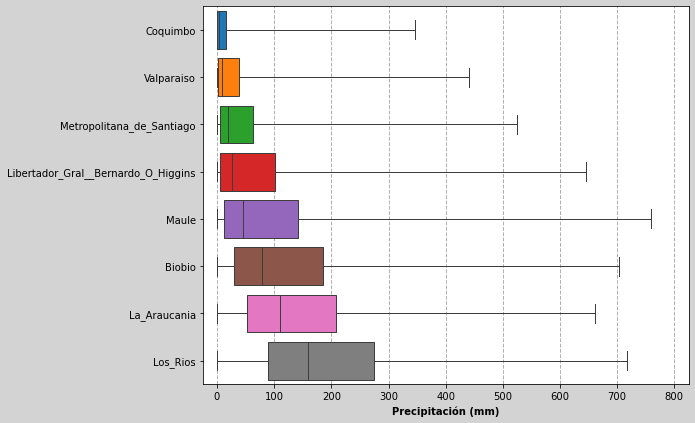

In [5]:
# figuras estaticas
for n, names in enumerate(precipitaciones.columns):
    plot_distribution(precipitaciones, names, "Precipitación (mm)", "Precipitaciones_distribucion_"+str(n)+names)

plot_allboxplot(precipitaciones, 0, 800, 25, "Precipitación (mm)", "Precipitaciones_boxplot")

## 2.2 Lectura y visualización archivo "banco_central.csv"

In [6]:
bc = pd.read_csv("Data/banco_central.csv", dtype=object)
bc['Periodo'] = pd.to_datetime(bc['Periodo'], errors="coerce", format="%Y-%m-%d %H:%M:%S UTC")
bc[bc.Periodo.duplicated(keep=False)]

,Periodo,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,PIB_Agropecuario_silvicola,PIB_Pesca,PIB_Mineria,PIB_Mineria_del_cobre,PIB_Otras_actividades_mineras,PIB_Industria_Manufacturera,PIB_Alimentos,PIB_Bebidas_y_tabaco,PIB_Textil,PIB_Maderas_y_muebles,PIB_Celulosa,PIB_Refinacion_de_petroleo,PIB_Quimica,PIB_Minerales_no_metalicos_y_metalica_basica,PIB_Productos_metalicos,PIB_Electricidad,PIB_Construccion,PIB_Comercio,PIB_Restaurantes_y_hoteles,PIB_Transporte,PIB_Comunicaciones,PIB_Servicios_financieros,PIB_Servicios_empresariales,PIB_Servicios_de_vivienda,PIB_Servicios_personales,PIB_Administracion_publica,PIB_a_costo_de_factores,Impuesto_al_valor_agregado,Derechos_de_Importacion,PIB,Precio_de_la_gasolina_en_EEUU_dolaresm3,Precio_de_la_onza_troy_de_oro_dolaresoz,Precio_de_la_onza_troy_de_plata_dolaresoz,Precio_del_cobre_refinado_BML_dolareslibra,Precio_del_diesel_centavos_de_dolargalon,Precio_del_gas_natural_dolaresmillon_de_unidades_termicas_britanicas,Precio_del_petroleo_Brent_dolaresbarril,Precio_del_kerosene_dolaresm3,Precio_del_petroleo_WTI_dolaresbarril,Precio_del_propano_centavos_de_dolargalon_DTN,Tipo_de_cambio_del_dolar_observado_diario,Ocupados,Ocupacion_en_Agricultura_INE,Ocupacion_en_Explotacion_de_minas_y_canteras_INE,Ocupacion_en_Industrias_manufactureras_INE,Ocupacion_en_Suministro_de_electricidad_INE,Ocupacion_en_Actividades_de_servicios_administrativos_y_de_apoyo_INE,Ocupacion_en_Actividades_profesionales_INE,Ocupacion_en_Actividades_inmobiliarias_INE,Ocupacion_en_Actividades_financieras_y_de_seguros_INE,Ocupacion_en_Informacion_y_comunicaciones_INE,Ocupacion_en_Transporte_y_almacenamiento_INE,Ocupacion_en_Actividades_de_alojamiento_y_de_servicio_de_comidas_INE,Ocupacion_en_Construccion_INE,Ocupacion_en_Comercio_INE,Ocupacion_en_Suministro_de_agua_evacuacion_de_aguas_residuales_INE,Ocupacion_en_Administracion_publica_y_defensa_INE,Ocupacion_en_Enseanza_INE,Ocupacion_en_Actividades_de_atencion_de_la_salud_humana_y_de_asistencia_social_INE,Ocupacion_en_Actividades_artisticas_INE,Ocupacion_en_Otras_actividades_de_servicios_INE,Ocupacion_en_Actividades_de_los_hogares_como_empleadores_INE,Ocupacion_en_Actividades_de_organizaciones_y_organos_extraterritoriales_INE,No_sabe__No_responde_Miles_de_personas,Tipo_de_cambio_nominal_multilateral___TCM,Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100,Indice_de_produccion_industrial,Indice_de_produccion_industrial__mineria,Indice_de_produccion_industrial_electricidad__gas_y_agua,Indice_de_produccion_industrial__manufacturera,Generacion_de_energia_electrica_CDEC_GWh,Indice_de_ventas_comercio_real_IVCM,Indice_de_ventas_comercio_real_no_durables_IVCM,Indice_de_ventas_comercio_real_durables_IVCM,Ventas_autos_nuevos
65,2018-08-01,109.690.834,994.693.267,101.027.633,1.051.861,931.900.957,106.248.833,117.404.143,109.458.386,110.578.221,167.218.756,618.107.584,127.494.583,114.044.798,135.911.049,134.337.385,352.713.059,155.499.282,282.857.251,761.910.666,10.666.085,113.232.043,205.964.209,753.121.123,229.592.623,341.668.896,771.082.628,110.815.907,240.435.294,648.893.077,417.627.795,686.888.472,120.587.594,945.484.562,17.263.425,585.841.147,11.510.209,104.105.171,515.511.264,12.603.131,53.532.204,1200.36,149.571,273.961.263,211.37,2.9677,73.13,5.319.667,67.99,97.452,656.250.909,870.719.435,641.968.676,216.799.913,918.492.209,423.859.029,216.848.578,293.308,827.010.405,163.289.707,166.817.299,589.477.133,452.211.964,742.884.096,164.123.096,388.556.009,470.714.131,788.049.995,489.831.763,113.514.038,27.638.401,359.984.869,144.446.086,NaN,102.822.273,911.086.301,102.691.109,983.228.221,108.792.744,105.596.535,654.060.172,113.525.936,103.995.337,15.375.472,38729
66,2018-08-01,109.690.834,994.693.267,101.027.633,1.051.861,931.900.957,106.248.833,117.404.143,109.458.386,110.578.221,167.218.756,618.107.584,127.494.583,114.044.798,135.911.049,134.337.385,352.7

In [7]:
bc            = bc.drop_duplicates(subset="Periodo").dropna(subset=["Periodo"]).rename({"Periodo":"date"}, axis=1).set_index("date")
bc            = bc.apply(lambda x: x.replace("a", np.nan, regex=True), axis=1)
display(bc.head())

,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,PIB_Agropecuario_silvicola,PIB_Pesca,PIB_Mineria,PIB_Mineria_del_cobre,PIB_Otras_actividades_mineras,PIB_Industria_Manufacturera,PIB_Alimentos,PIB_Bebidas_y_tabaco,PIB_Textil,PIB_Maderas_y_muebles,PIB_Celulosa,PIB_Refinacion_de_petroleo,PIB_Quimica,PIB_Minerales_no_metalicos_y_metalica_basica,PIB_Productos_metalicos,PIB_Electricidad,PIB_Construccion,PIB_Comercio,PIB_Restaurantes_y_hoteles,PIB_Transporte,PIB_Comunicaciones,PIB_Servicios_financieros,PIB_Servicios_empresariales,PIB_Servicios_de_vivienda,PIB_Servicios_personales,PIB_Administracion_publica,PIB_a_costo_de_factores,Impuesto_al_valor_agregado,Derechos_de_Importacion,PIB,Precio_de_la_gasolina_en_EEUU_dolaresm3,Precio_de_la_onza_troy_de_oro_dolaresoz,Precio_de_la_onza_troy_de_plata_dolaresoz,Precio_del_cobre_refinado_BML_dolareslibra,Precio_del_diesel_centavos_de_dolargalon,Precio_del_gas_natural_dolaresmillon_de_unidades_termicas_britanicas,Precio_del_petroleo_Brent_dolaresbarril,Precio_del_kerosene_dolaresm3,Precio_del_petroleo_WTI_dolaresbarril,Precio_del_propano_centavos_de_dolargalon_DTN,Tipo_de_cambio_del_dolar_observado_diario,Ocupados,Ocupacion_en_Agricultura_INE,Ocupacion_en_Explotacion_de_minas_y_canteras_INE,Ocupacion_en_Industrias_manufactureras_INE,Ocupacion_en_Suministro_de_electricidad_INE,Ocupacion_en_Actividades_de_servicios_administrativos_y_de_apoyo_INE,Ocupacion_en_Actividades_profesionales_INE,Ocupacion_en_Actividades_inmobiliarias_INE,Ocupacion_en_Actividades_financieras_y_de_seguros_INE,Ocupacion_en_Informacion_y_comunicaciones_INE,Ocupacion_en_Transporte_y_almacenamiento_INE,Ocupacion_en_Actividades_de_alojamiento_y_de_servicio_de_comidas_INE,Ocupacion_en_Construccion_INE,Ocupacion_en_Comercio_INE,Ocupacion_en_Suministro_de_agua_evacuacion_de_aguas_residuales_INE,Ocupacion_en_Administracion_publica_y_defensa_INE,Ocupacion_en_Enseanza_INE,Ocupacion_en_Actividades_de_atencion_de_la_salud_humana_y_de_asistencia_social_INE,Ocupacion_en_Actividades_artisticas_INE,Ocupacion_en_Otras_actividades_de_servicios_INE,Ocupacion_en_Actividades_de_los_hogares_como_empleadores_INE,Ocupacion_en_Actividades_de_organizaciones_y_organos_extraterritoriales_INE,No_sabe__No_responde_Miles_de_personas,Tipo_de_cambio_nominal_multilateral___TCM,Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100,Indice_de_produccion_industrial,Indice_de_produccion_industrial__mineria,Indice_de_produccion_industrial_electricidad__gas_y_agua,Indice_de_produccion_industrial__manufacturera,Generacion_de_energia_electrica_CDEC_GWh,Indice_de_ventas_comercio_real_IVCM,Indice_de_ventas_comercio_real_no_durables_IVCM,Indice_de_ventas_comercio_real_durables_IVCM,Ventas_autos_nuevos
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-03-01,102.796.218,10.546.824,978.554.365,102.297.537,114.994.919,110.729.395,100.064.328,103.163.651,103.405.852,579.846.819,570.624.122,123.491.343,110.356.254,131.350.889,130.648.285,367.818.436,162.692.807,330.305.467,643.366.109,974.948.182,103.469.519,184.460.073,807.709.837,212.409.058,301.314.934,710.242.818,115.489.064,202.838.669,546.694.889,337.915.263,5.691.837,11.393.886,793.471.519,140.103.913,512.994.015,108.482.797,896.688.023,659.936.009,118.109.613,7.638.022,1593.6,288.157,347.586.864,301.11,3.8117,109.24,76.520.246,92.91,89.171,472.484,799.068.585,798.092.771,258.428.756,901.504.814,360.108.494,18.951.548,229.653.619,547.033.124,19.153.327,155.736.824,498.854.717,341.857.582,682.423.108,151.916.628,349.444.258,445.435.266,587.837.412,362.517.856,82.567.788,201.875.908,416.124.956,190.085.519,NaN,93.621,865.903.468,102.761.705,98.915.705,NaN,108.387.837,580.480.672,NaN,NaN,NaN,28577
2013-04-01,101.664.842,999.272.757,927.333.293,104.485.589,102.199.311,106.098.291,102.600.107,101.937.319,102.766.884,374.895.706,606.504.665,11.702.736,10

In [8]:
bc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 611 entries, 2013-03-01 to 2008-12-01
Data columns (total 84 columns):
 #   Column                                                                              Non-Null Count  Dtype 
---  ------                                                                              --------------  ----- 
 0   Imacec_empalmado                                                                    298 non-null    object
 1   Imacec_produccion_de_bienes                                                         298 non-null    object
 2   Imacec_minero                                                                       298 non-null    object
 3   Imacec_industria                                                                    298 non-null    object
 4   Imacec_resto_de_bienes                                                              298 non-null    object
 5   Imacec_comercio                                                                     298

Wall time: 51 s


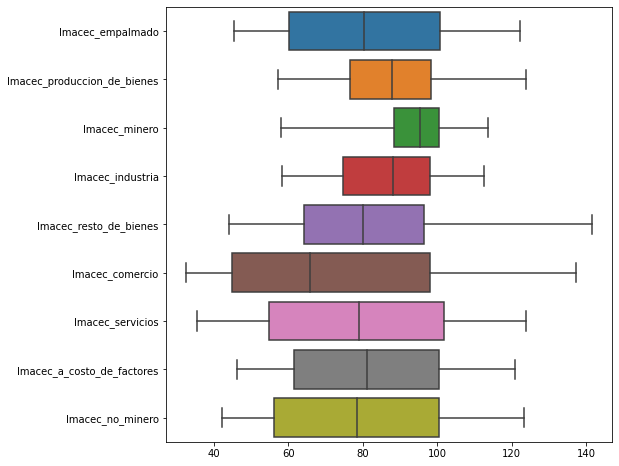

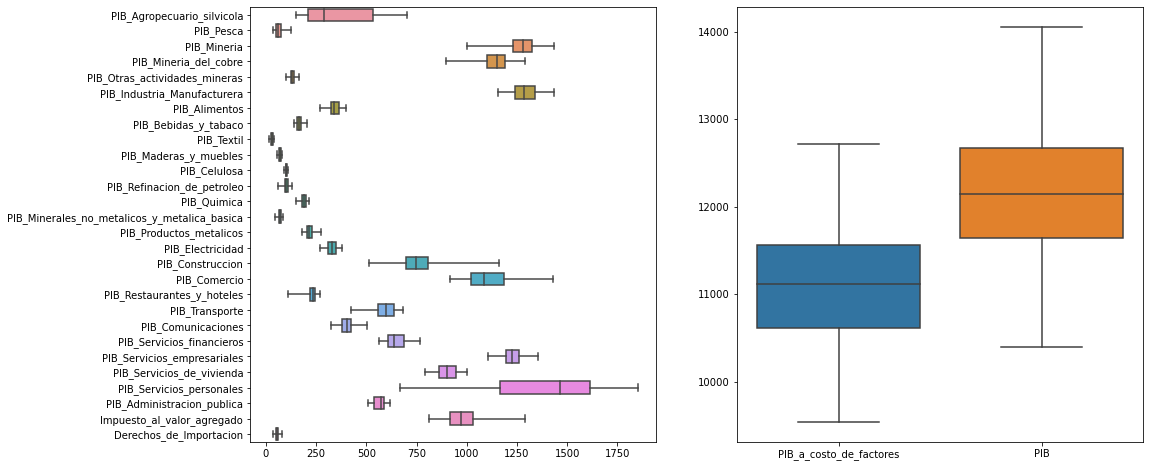

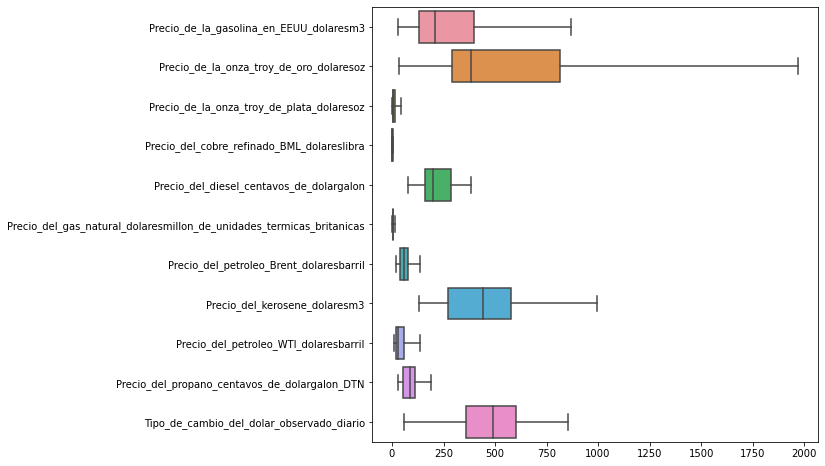

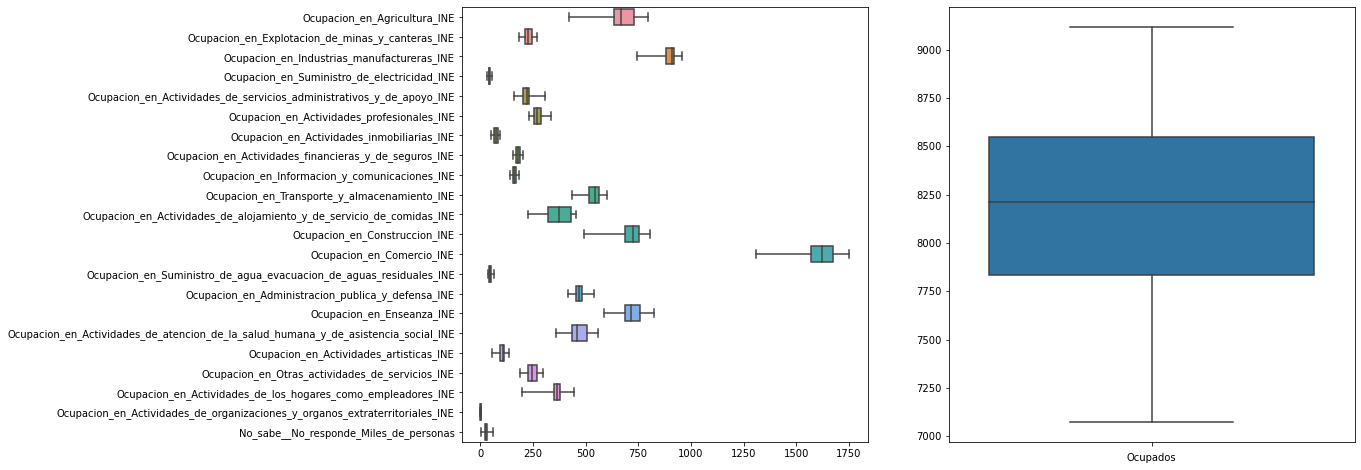

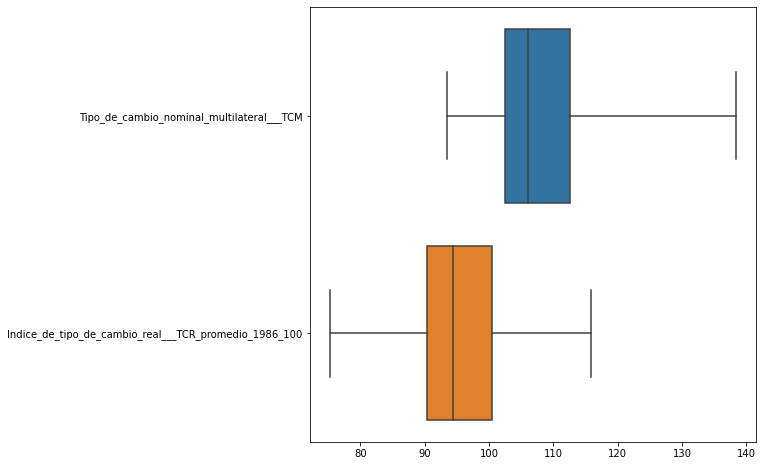

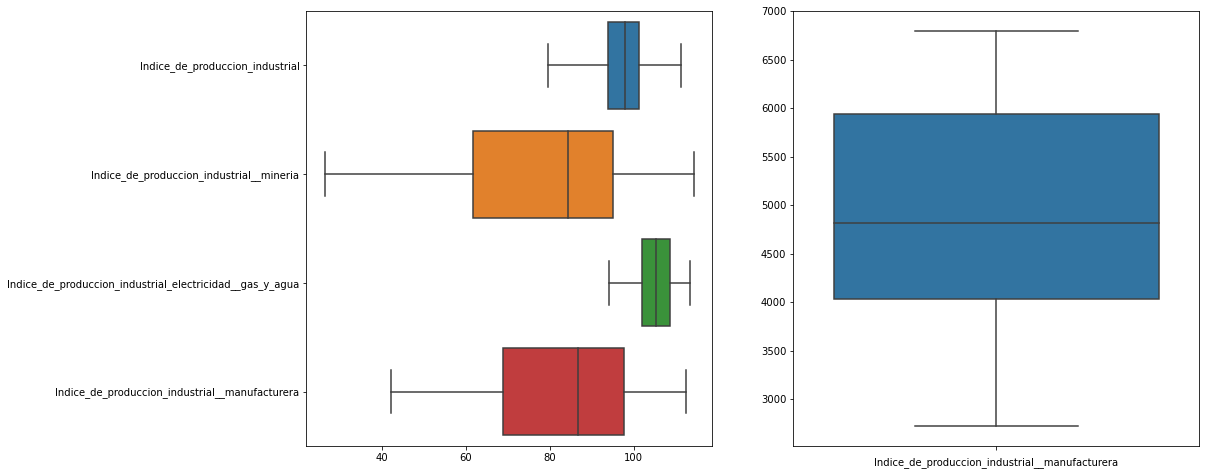

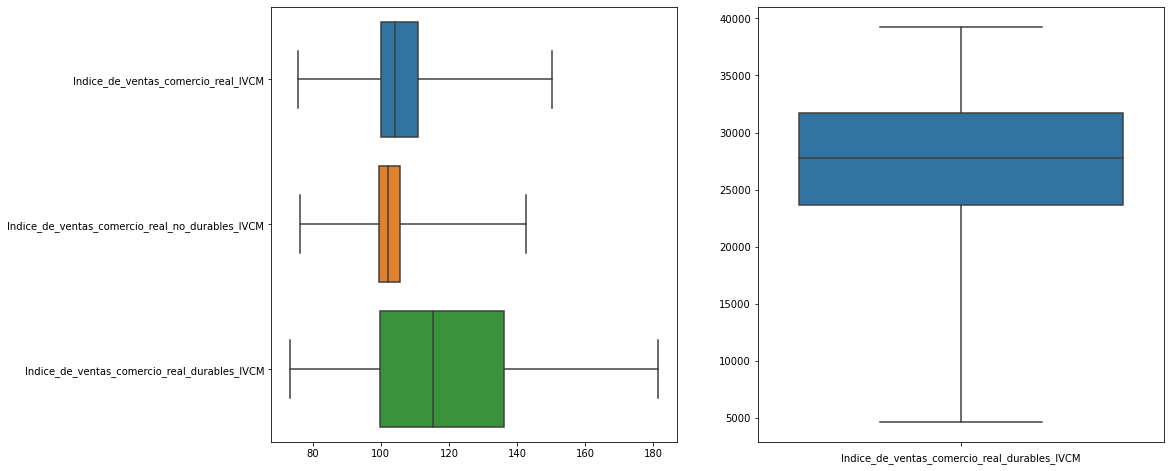

In [9]:
%%time
from reconstruccion_series import SeriesBC_IMACEC, SeriesBC_PIB, SeriesBC_Precio, SeriesBC_Ocupacion, SeriesBC_TCMTCR 
from reconstruccion_series import SeriesBC_Produccion, SeriesBc_Ventas
bc = SeriesBC_IMACEC(bc)
bc = SeriesBC_PIB(bc)
bc = SeriesBC_Precio(bc)
bc = SeriesBC_Ocupacion(bc)
bc = SeriesBC_TCMTCR(bc)
bc = SeriesBC_Produccion(bc)
bc = SeriesBc_Ventas(bc)

In [10]:
bc.to_csv("Output/Data/banco_central_preprocesado.csv")
del(n, names)
print(bc.dtypes.unique())

[dtype('float32')]


In [11]:
ExcelWorkbook = load_workbook('Output/Data/resumen_descriptivo.xlsx')
writer = pd.ExcelWriter('Output/Data/resumen_descriptivo.xlsx', engine = 'openpyxl')
writer.book = ExcelWorkbook
bc.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T.to_excel(writer, sheet_name="Banco Central")
writer.save()
writer.close()

## 2.3 Análisis y comentarios de ambos archivos: 

De acuerdo a lo observado anteriormente:
* Respecto a los registros duplicados y nulos en cada archivo:
    1. No hay registros de precipitación duplicados y ni datos anómalos, teniendo 496 observaciones para cada región en el archivo "precipitaciones.csv".
    2. En el archivo "banco_central.csv" existen dos fechas con archivos duplicados: "2018-08-01" y "2019-08-01". También existen registros con letra "a", lo que no es considerado como un valor nulo, por lo tanto se hace una limpieza de los datos duplicados y aquellos con valores como "a" son pasados a un valor NaN.
    3. Además, las diferentes variables económicas presentan registros en periodos, lo que genera datos nulos.
* Respecto al análisis descriptivo, histogramas y boxplot para el archivo "precipitaciones" se tiene:
    1. Desde la región más al norte (Coquimbo) hasta la región más al sur (Los Rios), se observa en los percentiles 25, 50 y 75, junto a la media un aumento en intensidad de la precipitación registrada. Misma tendencia no es compartida en los valores máximos.
    2. 

# 3. Visualización de datos.
## 3.1 función para gráficar series históricas de precipitaciones para un rango de fecha determinado

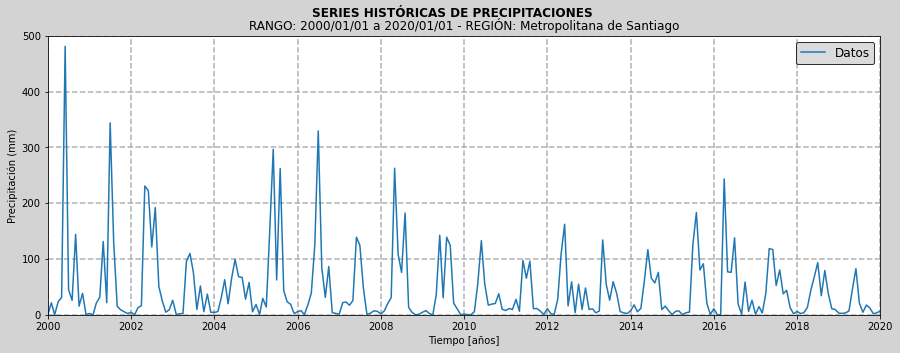

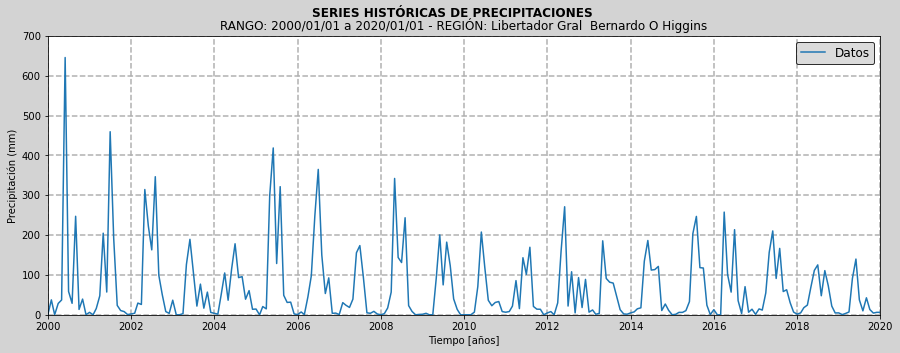

In [12]:
plotSTPrecipitación(precipitaciones, 'Metropolitana', "2000-01-01", "2020-01-01")
plotSTPrecipitación(precipitaciones, 'Libertador', "2000-01-01", "2020-01-01")
# # plotSTPrecipitación(precipitaciones, 'ADFAXC', "2000-01-01", "2020-01-01")

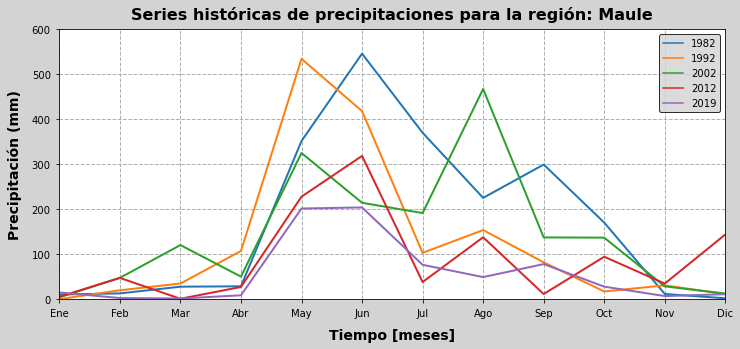

In [23]:
def plotSTbyYearPrecipitación(df, region_name, list_years):
    """
    Función para gráficar histogramas y series de tiempo de cada región.
    
    df           (DataFrame): Corresponde al dataframe sin outliers, duplicados, o caracteres que puedan ocasionar un error.
    region_name        (str): strings que corresponde al nombre de una región. 
    list_year         (list): Lista con años a considerar en el gráfico.
    """
    
    #eliminar NaN values y ordenar el índice
    df    = df.dropna().sort_index()
    Meses = {n+1: mes for n, mes in enumerate(["Ene",'Feb', "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"])}
    boolean_year_list = []
    for year in list_years:
        condicion = any(df.index.year.isin([year]))
        boolean_year_list.append(condicion)
        if condicion == False:
            print("Error: El año "+str(year)+' no se encuentra en el archivo.')
            break
    if all(boolean_year_list) == True:

        boolean_list = [region_name in nregion for nregion in df.columns]
        if any(boolean_list) == True:
            fig, ax = plt.subplots(ncols=1, figsize=(10,5), gridspec_kw={'left'  :0.05, 'right' :0.975, 'top'   :0.900, 'bottom':0.15},
                                facecolor='lightgrey', edgecolor='w')
            col_name = df.columns[np.where(boolean_list)[0]][0]
            df['Años']         = df.index.year
            df['Meses']        = df.index.month
            df["Nombre_meses"] = df.Meses.map(Meses)
            df          = df.loc[df['Años'].isin([1982, 1992, 2002, 2012, 2019])]
            #serie de tiempo
            sns.lineplot(data=df, x="Meses", y=col_name, ci=None, hue="Años", ax=ax, lw=2, palette="tab10")
            
            #definición de limites
            if df[col_name].max() < 10:
                vmax  = round_up(df[col_name].max(), -1)
            elif df[col_name].max() > 200:
                vmax  = round_up(df[col_name].max(), -2)
            else:
                vmax  = round_up(df[col_name].max()*1.1, -1)
            ax.set_xlim(1, 12)
            ax.set_ylim(0,vmax)
            #definición de etiquetas del eje x e y
            ax.set_ylabel("Precipitación (mm)", fontweight='bold', fontsize=14, labelpad=10)
            ax.set_xlabel("Tiempo [meses]", fontweight='bold', fontsize=14, labelpad=10)
            #aumento de tamaño en xticks e yticks
            ax.set_xticks(df.Meses.unique().tolist())
            ax.set_xticklabels(df.Nombre_meses.unique().tolist())
            ax.tick_params(labelsize = 10, pad=5)
            #incorpora la legenda
            ax.legend(fontsize=10, facecolor='lightgrey', edgecolor='k')
            #difine forma de lineas que representan a la grilla
            ax.grid(ls="--", lw=1, zorder = 1)
            #definición de titulo
            ax.set_title("Series históricas de precipitaciones para la región: "+col_name, fontsize=16, fontweight='bold', pad = 10)
            #guardar imagen 
            fig.savefig('Output/Plot/Precipitaciones_byYear_'+col_name+'.png', dpi=300, facecolor='lightgrey', edgecolor='w')
        else:
            print("No se encuentra la región: "+region_name+" dentro del archivo.")
            
    return
plotSTbyYearPrecipitación(precipitaciones, 'Maule', [1982, 1992, 2002, 2012, 2019])

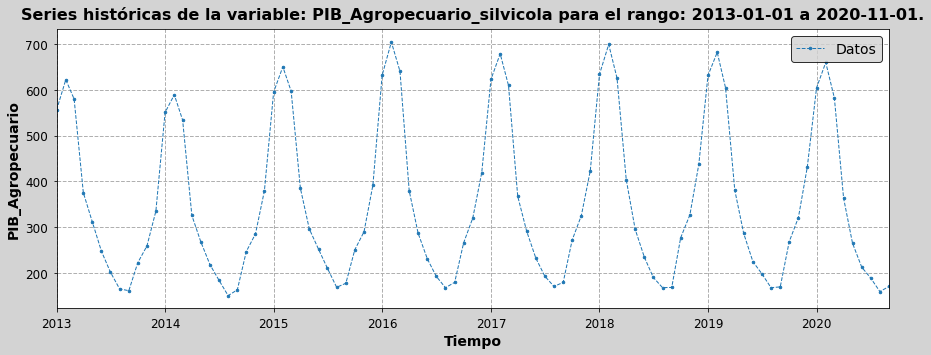

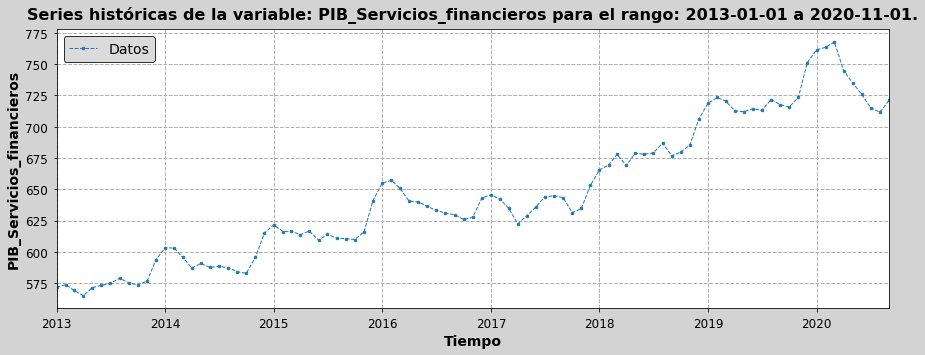

In [14]:
plotSTBancoCentral(bc, "PIB_Agropecuario", "2013-01-01", '2020-11-01')
plotSTBancoCentral(bc, "PIB_Servicios_financieros", "2013-01-01", '2020-11-01')